In [2]:
import os, importlib, sys, time, glob

In [3]:
import numpy as np
from scipy import linalg, stats, ndimage, io
from scipy.sparse import diags

In [4]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':13})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [5]:
import ladyns as ldn
import ladyns.inference as inf

In [7]:
save_dir = "../temp/Section_3"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 1. simulation information

In [8]:
num_time = 50

## cross precision

In [9]:
lambda_diag = 20

In [15]:
true_omega = np.load('%s/result_true_omega.npz'%save_dir)
Sigmas_true = true_omega["Sigmas_true"]
Omegas_true = true_omega["Omegas_true"]
dsprs_true = 2*Omegas_true - Omegas_true @ (Sigmas_true + lambda_diag*np.eye(2*num_time)) @ Omegas_true

In [16]:
Omega_true = np.mean(Omegas_true, 0)

In [17]:
dspr_true = np.mean(dsprs_true, 0)

Text(0, 0.5, 'series 1 at time $t$ ms')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino


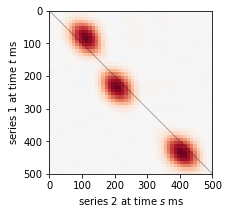

In [19]:
fig, ax = plt.subplots(figsize=(3,3))
ldn.imshow(Omega_true[:num_time,num_time:], 
           time=[0,500], identity=True, vmax=0.0004)
plt.xlabel(r"series 2 at time $s$ ms"); plt.ylabel(r"series 1 at time $t$ ms")
# plt.colorbar()

In [20]:
ths_W = 4*np.max(np.abs(Omega_true[num_time-20:num_time,num_time:num_time+20]))

Text(0, 0.5, 'series 1 at time $t$')

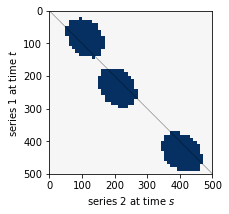

In [22]:
fig, ax = plt.subplots(figsize=(3,3))
ldn.imshow(np.abs(Omega_true[:num_time,num_time:]) > ths_W, time=[0,500], identity=True)
plt.xlabel(r"series 2 at time $s$"); plt.ylabel(r"series 1 at time $t$")

In [23]:
H0 = np.zeros((num_time, num_time))
num_blobs = 0

mask_cp = np.abs(Omega_true[:num_time,num_time:]) > ths_W
while np.any(mask_cp):
    num_blobs += 1
    queue = [tuple(np.transpose(np.where(mask_cp))[0])]
    mask_cp[queue[0]] = False
    while len(queue) > 0:
        cur = queue.pop(0)
        H0[cur[0], cur[1]] = num_blobs
        if cur[0] > 0:
            if mask_cp[cur[0]-1, cur[1]]:
                queue.append((cur[0]-1, cur[1]))
                mask_cp[cur[0]-1, cur[1]] = False
        if cur[0] < num_time-1:
            if mask_cp[cur[0]+1, cur[1]]:
                queue.append((cur[0]+1, cur[1]))
                mask_cp[cur[0]+1, cur[1]] = False
        if cur[1] > 0:
            if mask_cp[cur[0], cur[1]-1]:
                queue.append((cur[0], cur[1]-1))
                mask_cp[cur[0], cur[1]-1] = False
        if cur[1] < num_time-1:
            if mask_cp[cur[0], cur[1]+1]:
                queue.append((cur[0], cur[1]+1))
                mask_cp[cur[0], cur[1]+1] = False
H0 = H0 == (np.arange(num_blobs)+1)[:,None,None]

# 1. analysis on simulated estimation 

In [25]:
snrs = np.sqrt([0.003, 0.004, 0.005, 0.006, 0.007, 0.008])

In [26]:
num_bst = 200

In [27]:
num_sim = np.min([len(glob.glob("%s/result_sim_%.1d_*.npz"%(save_dir, i))) 
                 for i, snr in enumerate(snrs)])

In [28]:
num_sim

200

In [29]:
offset_cross = 10
offset_auto = 10

## load simulation results

In [33]:
Omegas_sim = np.zeros((len(snrs), num_sim, 2*num_time, 2*num_time))
Sigmas_sim = np.zeros((len(snrs), num_sim, 2*num_time, 2*num_time))

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        sys.__stdout__.write("%d-%d-th simulation\n"%(iter_snr+1, iter_sim+1))
        sys.__stdout__.flush()

        result = np.load("%s/result_sim_%.1d_%.3d.npz"
                         %(save_dir,iter_snr,iter_sim))
        Omega_est = result["Omega_est"]; Sigma_est=result["Sigma_est"]

        Omegas_sim[iter_snr, iter_sim] = Omega_est
        Sigmas_sim[iter_snr, iter_sim] = Sigma_est

Omegas_bst = result["Omegas_bst"]
Sigmas_bst = result["Sigmas_bst"]

1-1-th simulation
1-2-th simulation
1-3-th simulation
1-4-th simulation
1-5-th simulation
1-6-th simulation
1-7-th simulation
1-8-th simulation
1-9-th simulation
1-10-th simulation
1-11-th simulation
1-12-th simulation
1-13-th simulation
1-14-th simulation
1-15-th simulation
1-16-th simulation
1-17-th simulation
1-18-th simulation
1-19-th simulation
1-20-th simulation
1-21-th simulation
1-22-th simulation
1-23-th simulation
1-24-th simulation
1-25-th simulation
1-26-th simulation
1-27-th simulation
1-28-th simulation
1-29-th simulation
1-30-th simulation
1-31-th simulation
1-32-th simulation
1-33-th simulation
1-34-th simulation
1-35-th simulation
1-36-th simulation
1-37-th simulation
1-38-th simulation
1-39-th simulation
1-40-th simulation
1-41-th simulation
1-42-th simulation
1-43-th simulation
1-44-th simulation
1-45-th simulation
1-46-th simulation
1-47-th simulation
1-48-th simulation
1-49-th simulation
1-50-th simulation
1-51-th simulation
1-52-th simulation
1-53-th simulation
1-

3-29-th simulation
3-30-th simulation
3-31-th simulation
3-32-th simulation
3-33-th simulation
3-34-th simulation
3-35-th simulation
3-36-th simulation
3-37-th simulation
3-38-th simulation
3-39-th simulation
3-40-th simulation
3-41-th simulation
3-42-th simulation
3-43-th simulation
3-44-th simulation
3-45-th simulation
3-46-th simulation
3-47-th simulation
3-48-th simulation
3-49-th simulation
3-50-th simulation
3-51-th simulation
3-52-th simulation
3-53-th simulation
3-54-th simulation
3-55-th simulation
3-56-th simulation
3-57-th simulation
3-58-th simulation
3-59-th simulation
3-60-th simulation
3-61-th simulation
3-62-th simulation
3-63-th simulation
3-64-th simulation
3-65-th simulation
3-66-th simulation
3-67-th simulation
3-68-th simulation
3-69-th simulation
3-70-th simulation
3-71-th simulation
3-72-th simulation
3-73-th simulation
3-74-th simulation
3-75-th simulation
3-76-th simulation
3-77-th simulation
3-78-th simulation
3-79-th simulation
3-80-th simulation
3-81-th simu

5-54-th simulation
5-55-th simulation
5-56-th simulation
5-57-th simulation
5-58-th simulation
5-59-th simulation
5-60-th simulation
5-61-th simulation
5-62-th simulation
5-63-th simulation
5-64-th simulation
5-65-th simulation
5-66-th simulation
5-67-th simulation
5-68-th simulation
5-69-th simulation
5-70-th simulation
5-71-th simulation
5-72-th simulation
5-73-th simulation
5-74-th simulation
5-75-th simulation
5-76-th simulation
5-77-th simulation
5-78-th simulation
5-79-th simulation
5-80-th simulation
5-81-th simulation
5-82-th simulation
5-83-th simulation
5-84-th simulation
5-85-th simulation
5-86-th simulation
5-87-th simulation
5-88-th simulation
5-89-th simulation
5-90-th simulation
5-91-th simulation
5-92-th simulation
5-93-th simulation
5-94-th simulation
5-95-th simulation
5-96-th simulation
5-97-th simulation
5-98-th simulation
5-99-th simulation
5-100-th simulation
5-101-th simulation
5-102-th simulation
5-103-th simulation
5-104-th simulation
5-105-th simulation
5-106-

## simulation result

In [34]:
dsprs_sim = 2*Omegas_sim - Omegas_sim @ (Sigmas_sim + lambda_diag*np.eye(2*num_time)) @ Omegas_sim

In [35]:
std_dspr_sim = np.std(dsprs_sim, 1)

In [53]:
dsprs_bst = 2*Omegas_bst - Omegas_bst @ (Sigmas_bst + lambda_diag*np.eye(2*num_time))@ Omegas_bst

In [54]:
std_dspr_bst = np.std(dsprs_bst, 0)

## plots

([], [])

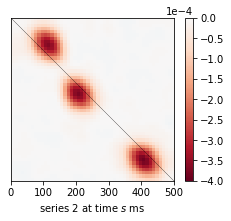

In [52]:
plt.figure(figsize=(4,3))
ldn.imshow(np.mean(dsprs_sim[3,:,:num_time,num_time:], 0), 
           time=[0,500], identity=True, vmax=0.0004)
cbar = plt.colorbar(); 
# plt.ylabel(r'series 1 at time $t$');
cbar.ax.set_ylim(-0.0004,0); cbar.formatter.set_powerlimits((0, 0))
plt.xlabel(r'series 2 at time $s$ ms')
plt.yticks((),())

Text(0.5, 0, 'series 2 at time $s$')

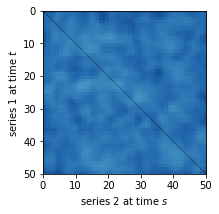

In [60]:
plt.figure(figsize=(3,3))
ldn.imshow(std_dspr_bst[:num_time,num_time:], time=[0,num_time], identity=True,
           vmax=7e-5)
# plt.colorbar()
# plt.title(r'$\hat{\sigma}_{bst}$'); 
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')

([], [])

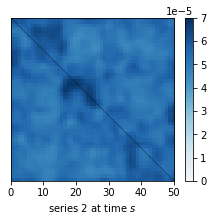

In [62]:
plt.figure(figsize=(4,3))
ldn.imshow(std_dspr_sim[-1,:num_time,num_time:], time=[0,num_time], identity=True,
           vmax=7e-5)
cbar = plt.colorbar()
cbar.ax.set_ylim(0,7e-5); cbar.formatter.set_powerlimits((0, 0))
# plt.title(r'$\hat{\sigma}_{sim}$'); plt.ylabel(r'series 1 at time $t$'); 
plt.xlabel(r'series 2 at time $s$')
plt.yticks([],[])

Text(0.5, 0, 'series 2 at time $s$')

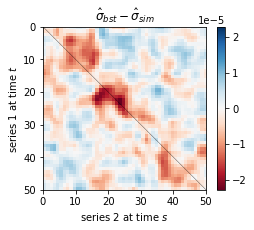

In [117]:
plt.figure(figsize=(4,3))
ldn.imshow(std_dspr_bst[:num_time,num_time:] - std_dspr_sim[-1,:num_time,num_time:], time=[0,num_time], identity=True)
plt.colorbar()
plt.title(r'$\hat{\sigma}_{bst} - \hat{\sigma}_{sim}$');plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')

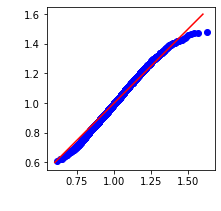

In [118]:
# import matplotlib.gridspec as gridspec
plt.figure(figsize=(3,3))
# gridspec.GridSpec(1,4); plt.subplot2grid((1,4), (0,0), colspan=3, rowspan=1)
stats.probplot(np.square((std_dspr_bst[:num_time,num_time:])[np.sum(H0,0)==0]
                         /(std_dspr_sim[-1,:num_time,num_time:])[np.sum(H0,0)==0]).flatten(),
                dist='f', sparams=(num_bst-1, num_sim-1), plot=plt, fit=False)
plt.ylabel(r' ', fontsize=12); plt.xlabel(r' ', fontsize=12); plt.title('')
plt.plot([0.6,1.6],[0.6,1.6],color='red')
# ax = plt.subplot2grid((1,4), (0,3))
# ax.axis('off')

# check normality

In [65]:
x_grid = np.linspace(-4, 4, 41)
dnorm_grid = stats.norm(0,1).pdf(x_grid)

In [68]:
rand_inds = np.concatenate([
    np.random.choice(np.where(np.sum(H0,0).flatten() == 0)[0], 3, False),
    np.random.choice(np.where(np.sum(H0,0).flatten() != 0)[0], 3, False)
])

Text(0, 0.5, 'connection')

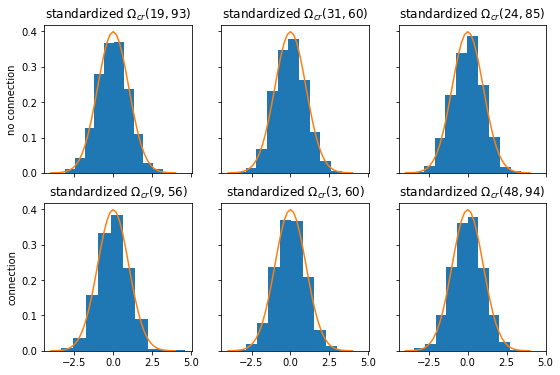

In [69]:
fig, axes = plt.subplots(2, 3, sharey=True, sharex=True, figsize=[9.0, 6.0],
                         facecolor='white')
for label, ax in zip(rand_inds, axes.flatten()):
    ax.hist(((dsprs_sim[...,int(label/num_time),num_time+label%num_time]
              - np.mean(dsprs_sim,1)[:,None,int(label/num_time),num_time+label%num_time])
             / std_dspr_sim[:,None,int(label/num_time),num_time+label%num_time]).flatten(),
             density=True)
    ax.plot(x_grid, dnorm_grid)
    ax.set_title(r'standardized $\Omega_{cr}(%d,%d)$'
                  %(int(label/num_time),num_time+label%num_time))
axes[0,0].set_ylabel('no connection')
axes[1,0].set_ylabel('connection')

Text(0.5, 0, 'quantiles of $N(0,1)$')

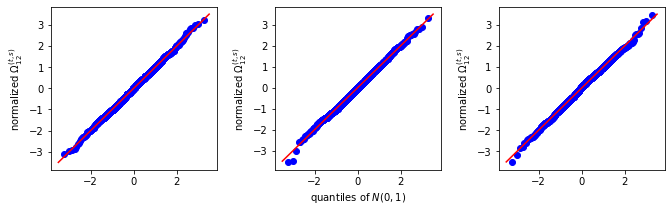

In [73]:
fig, axes = plt.subplots(1, 3, #sharey=True, sharex=True,
                         figsize=[11.0, 3.0], facecolor='white')
plt.subplots_adjust(wspace=0.35)
for label, ax in zip(rand_inds[:3], axes.flatten()):
    stats.probplot(((dsprs_sim[...,int(label/num_time),num_time+label%num_time]
                   - np.mean(dsprs_sim,1)[:,None,int(label/num_time),num_time+label%num_time])
                   / std_dspr_sim[:,None,int(label/num_time),num_time+label%num_time]).flatten(),
                   dist='norm', fit=False, plot=ax)
    ax.plot((-3.5,3.5),(-3.5,3.5), color='red')
    ax.set_xlabel(r''); ax.set_ylabel(r'normalized $\Omega_{12}^{(t,s)}$')
    ax.set_title('')

axes[1].set_xlabel(r'quantiles of $N(0,1)$')
#     ax.set_title(r'Q-Q $\Omega_{12}^{(%d,%d)}$ vs. norm'
#                   %(int(label/num_time),num_time+label%num_time))
# axes[0,0].set_ylabel('no connection')
# axes[1,0].set_ylabel('connection')

# 3. FDR from estimated variance

## p-values

In [526]:
roi = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross-1)

In [527]:
pvals_bst = np.zeros((len(snrs), num_sim, num_time, num_time))

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        sys.__stdout__.write("%d-%d-th simulation\n"%(iter_snr+1, iter_sim+1))
        sys.__stdout__.flush()

        result = np.load("%s/result_sim_%.1d_%.3d.npz"%(save_dir,iter_snr, iter_sim))
        Omega_est=result["Omega_est"]; Sigma_est=result["Sigma_est"]
        Omegas_bst=result["Omegas_bst"]; Sigmas_bst=result["Sigmas_bst"]
        
        dspr_est = 2*Omega_est - Omega_est@(Sigma_est + lambda_diag*np.eye(2*num_time))@Omega_est
        dsprs_bst = 2*Omegas_bst - Omegas_bst@(Sigmas_bst + lambda_diag*np.eye(2*num_time))@Omegas_bst
        std_dspr_bst = np.std(dsprs_bst, 0)
        
        dist_dspr_est = (np.abs(dspr_est)[:num_time,num_time:]
                         /std_dspr_bst[:num_time,num_time:]).flatten()
        dist_dspr_bst = (np.abs(dsprs_bst)[:,:num_time,num_time:]
                         /std_dspr_bst[:num_time,num_time:]).flatten()
        
        pvals_bst[iter_snr, iter_sim] = np.clip(2*stats.norm.cdf(
            -np.abs(dspr_est) 
            /std_dspr_bst)[:num_time,num_time:], 1e-10, 1-1e-10)
        pvals_bst[iter_snr, iter_sim][np.logical_not(roi)] = 0.5

1-1-th simulation
1-2-th simulation
1-3-th simulation
1-4-th simulation
1-5-th simulation
1-6-th simulation
1-7-th simulation
1-8-th simulation
1-9-th simulation
1-10-th simulation
1-11-th simulation
1-12-th simulation
1-13-th simulation
1-14-th simulation
1-15-th simulation
1-16-th simulation
1-17-th simulation
1-18-th simulation
1-19-th simulation
1-20-th simulation
1-21-th simulation
1-22-th simulation
1-23-th simulation
1-24-th simulation
1-25-th simulation
1-26-th simulation
1-27-th simulation
1-28-th simulation
1-29-th simulation
1-30-th simulation
1-31-th simulation
1-32-th simulation
1-33-th simulation
1-34-th simulation
1-35-th simulation
1-36-th simulation
1-37-th simulation
1-38-th simulation
1-39-th simulation
1-40-th simulation
1-41-th simulation
1-42-th simulation
1-43-th simulation
1-44-th simulation
1-45-th simulation
1-46-th simulation
1-47-th simulation
1-48-th simulation
1-49-th simulation
1-50-th simulation
1-51-th simulation
1-52-th simulation
1-53-th simulation
1-

3-23-th simulation
3-24-th simulation
3-25-th simulation
3-26-th simulation
3-27-th simulation
3-28-th simulation
3-29-th simulation
3-30-th simulation
3-31-th simulation
3-32-th simulation
3-33-th simulation
3-34-th simulation
3-35-th simulation
3-36-th simulation
3-37-th simulation
3-38-th simulation
3-39-th simulation
3-40-th simulation
3-41-th simulation
3-42-th simulation
3-43-th simulation
3-44-th simulation
3-45-th simulation
3-46-th simulation
3-47-th simulation
3-48-th simulation
3-49-th simulation
3-50-th simulation
3-51-th simulation
3-52-th simulation
3-53-th simulation
3-54-th simulation
3-55-th simulation
3-56-th simulation
3-57-th simulation
3-58-th simulation
3-59-th simulation
3-60-th simulation
3-61-th simulation
3-62-th simulation
3-63-th simulation
3-64-th simulation
3-65-th simulation
3-66-th simulation
3-67-th simulation
3-68-th simulation
3-69-th simulation
3-70-th simulation
3-71-th simulation
3-72-th simulation
3-73-th simulation
3-74-th simulation
3-75-th simu

5-45-th simulation
5-46-th simulation
5-47-th simulation
5-48-th simulation
5-49-th simulation
5-50-th simulation
5-51-th simulation
5-52-th simulation
5-53-th simulation
5-54-th simulation
5-55-th simulation
5-56-th simulation
5-57-th simulation
5-58-th simulation
5-59-th simulation
5-60-th simulation
5-61-th simulation
5-62-th simulation
5-63-th simulation
5-64-th simulation
5-65-th simulation
5-66-th simulation
5-67-th simulation
5-68-th simulation
5-69-th simulation
5-70-th simulation
5-71-th simulation
5-72-th simulation
5-73-th simulation
5-74-th simulation
5-75-th simulation
5-76-th simulation
5-77-th simulation
5-78-th simulation
5-79-th simulation
5-80-th simulation
5-81-th simulation
5-82-th simulation
5-83-th simulation
5-84-th simulation
5-85-th simulation
5-86-th simulation
5-87-th simulation
5-88-th simulation
5-89-th simulation
5-90-th simulation
5-91-th simulation
5-92-th simulation
5-93-th simulation
5-94-th simulation
5-95-th simulation
5-96-th simulation
5-97-th simu

## get discoveries

In [529]:
alphas = np.linspace(0, 0.1, 11)

In [530]:
rejs_BH_bst = np.full((len(snrs), num_sim,) + alphas.shape + (num_time, num_time), False)

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        sys.__stdout__.write('%d-%d-th simulation\n'%(iter_snr+1, iter_sim+1))
        sys.__stdout__.flush()  
        
        # BH process
        p_sorted = np.concatenate([[0], np.sort(pvals_bst[iter_snr, iter_sim].flatten())])
        for iter_alpha, alpha in enumerate(alphas):
            k_hat = np.max(np.where(np.linspace(0, alpha, num_time**2+1) >= p_sorted))        
            rejs_BH_bst[iter_snr, iter_sim, iter_alpha] \
            = pvals_bst[iter_snr, iter_sim] <= k_hat * alpha / num_time**2

1-1-th simulation
1-2-th simulation
1-3-th simulation
1-4-th simulation
1-5-th simulation
1-6-th simulation
1-7-th simulation
1-8-th simulation
1-9-th simulation
1-10-th simulation
1-11-th simulation
1-12-th simulation
1-13-th simulation
1-14-th simulation
1-15-th simulation
1-16-th simulation
1-17-th simulation
1-18-th simulation
1-19-th simulation
1-20-th simulation
1-21-th simulation
1-22-th simulation
1-23-th simulation
1-24-th simulation
1-25-th simulation
1-26-th simulation
1-27-th simulation
1-28-th simulation
1-29-th simulation
1-30-th simulation
1-31-th simulation
1-32-th simulation
1-33-th simulation
1-34-th simulation
1-35-th simulation
1-36-th simulation
1-37-th simulation
1-38-th simulation
1-39-th simulation
1-40-th simulation
1-41-th simulation
1-42-th simulation
1-43-th simulation
1-44-th simulation
1-45-th simulation
1-46-th simulation
1-47-th simulation
1-48-th simulation
1-49-th simulation
1-50-th simulation
1-51-th simulation
1-52-th simulation
1-53-th simulation
1-

3-24-th simulation
3-25-th simulation
3-26-th simulation
3-27-th simulation
3-28-th simulation
3-29-th simulation
3-30-th simulation
3-31-th simulation
3-32-th simulation
3-33-th simulation
3-34-th simulation
3-35-th simulation
3-36-th simulation
3-37-th simulation
3-38-th simulation
3-39-th simulation
3-40-th simulation
3-41-th simulation
3-42-th simulation
3-43-th simulation
3-44-th simulation
3-45-th simulation
3-46-th simulation
3-47-th simulation
3-48-th simulation
3-49-th simulation
3-50-th simulation
3-51-th simulation
3-52-th simulation
3-53-th simulation
3-54-th simulation
3-55-th simulation
3-56-th simulation
3-57-th simulation
3-58-th simulation
3-59-th simulation
3-60-th simulation
3-61-th simulation
3-62-th simulation
3-63-th simulation
3-64-th simulation
3-65-th simulation
3-66-th simulation
3-67-th simulation
3-68-th simulation
3-69-th simulation
3-70-th simulation
3-71-th simulation
3-72-th simulation
3-73-th simulation
3-74-th simulation
3-75-th simulation
3-76-th simu

5-46-th simulation
5-47-th simulation
5-48-th simulation
5-49-th simulation
5-50-th simulation
5-51-th simulation
5-52-th simulation
5-53-th simulation
5-54-th simulation
5-55-th simulation
5-56-th simulation
5-57-th simulation
5-58-th simulation
5-59-th simulation
5-60-th simulation
5-61-th simulation
5-62-th simulation
5-63-th simulation
5-64-th simulation
5-65-th simulation
5-66-th simulation
5-67-th simulation
5-68-th simulation
5-69-th simulation
5-70-th simulation
5-71-th simulation
5-72-th simulation
5-73-th simulation
5-74-th simulation
5-75-th simulation
5-76-th simulation
5-77-th simulation
5-78-th simulation
5-79-th simulation
5-80-th simulation
5-81-th simulation
5-82-th simulation
5-83-th simulation
5-84-th simulation
5-85-th simulation
5-86-th simulation
5-87-th simulation
5-88-th simulation
5-89-th simulation
5-90-th simulation
5-91-th simulation
5-92-th simulation
5-93-th simulation
5-94-th simulation
5-95-th simulation
5-96-th simulation
5-97-th simulation
5-98-th simu

## get rejected blobs

In [531]:
rej_blobs_BH_bst = np.zeros((len(snrs), num_sim,) + alphas.shape + (num_time, num_time))
num_blobs_BH_bst = np.zeros((len(snrs), num_sim,) + alphas.shape)

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        for iter_alpha, alpha in enumerate(alphas):
            mask_cp = rejs_BH_bst[iter_snr, iter_sim, iter_alpha].copy()
            iter_blob = 0
            while np.any(mask_cp):
                iter_blob += 1
                queue = [tuple(np.transpose(np.where(mask_cp))[0])]
                mask_cp[queue[0]] = False
                while len(queue) > 0:
                    cur = queue.pop(0)
                    rej_blobs_BH_bst[iter_snr, iter_sim, iter_alpha,
                                        cur[0], cur[1]] = iter_blob
                    if cur[0] > 0:
                        if mask_cp[cur[0]-1, cur[1]]:
                            queue.append((cur[0]-1, cur[1]))
                            mask_cp[cur[0]-1, cur[1]] = False
                    if cur[0] < num_time-1:
                        if mask_cp[cur[0]+1, cur[1]]:
                            queue.append((cur[0]+1, cur[1]))
                            mask_cp[cur[0]+1, cur[1]] = False
                    if cur[1] > 0:
                        if mask_cp[cur[0], cur[1]-1]:
                            queue.append((cur[0], cur[1]-1))
                            mask_cp[cur[0], cur[1]-1] = False
                    if cur[1] < num_time-1:
                        if mask_cp[cur[0], cur[1]+1]:
                            queue.append((cur[0], cur[1]+1))
                            mask_cp[cur[0], cur[1]+1] = False
            num_blobs_BH_bst[iter_snr, iter_sim, iter_alpha] = iter_blob

## calculate fdrs

In [533]:
H0_sm = np.array([np.sum(H0,0) > 0 for _ in enumerate(snrs)])

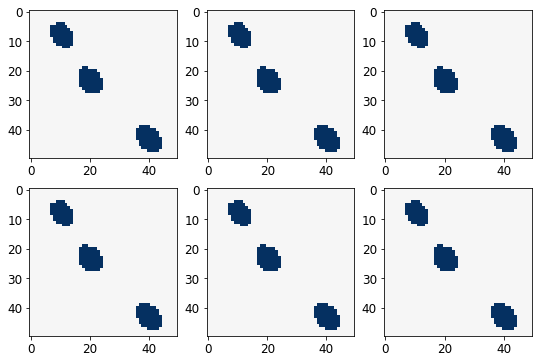

In [534]:
plt.figure(figsize=(9,6))
for i, H0_i_sm in enumerate(H0_sm):
    plt.subplot(2,3,i+1); ldn.imshow(H0_i_sm)

In [535]:
fdps_BH_bst = np.sum(rejs_BH_bst > H0_sm[:,None,None], (-2,-1)) \
           / np.maximum(np.sum(rejs_BH_bst, (-2,-1)), 1)  

fnps_BH_bst = np.sum(rejs_BH_bst < H0_sm[:,None,None], (-2,-1)) \
            / np.maximum(np.sum(H0_sm,(-1,-2)), 1)[:,None,None]

In [538]:
fcds_BH_bst = num_blobs_BH_bst.copy()
for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        for iter_alpha, _ in enumerate(alphas):
            fcds_BH_bst[iter_snr, iter_sim, iter_alpha] -= np.sum(np.unique(
                rej_blobs_BH_bst[iter_snr, iter_sim, iter_alpha, np.any(H0,0)])> 0)
        
fcdps_BH_bst = fcds_BH_bst / np.maximum(num_blobs_BH_bst, 1)

In [539]:
fcnps_BH_bst = np.sum(np.all(
    np.logical_or((rejs_BH_bst[...,None,:,:] < H0), np.logical_not(H0))
    , (-2,-1)), -1) /np.maximum(H0.shape[0], 1)

## plots

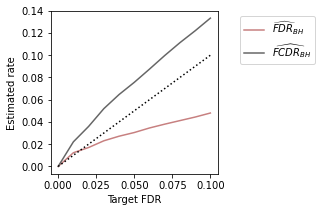

In [134]:
plt.figure(figsize=(3,3))
plt.plot(alphas, np.mean(fdps_BH_bst, (0,1)), color=(200/256, 128/256, 128/256), label=r"$\widehat{FDR}_{BH}$")
plt.plot(alphas, np.mean(fcdps_BH_bst, (0,1)), color=(102/256, 102/256, 102/256), label = r"$\widehat{FCDR}_{BH}$")
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"Estimated rate"); #plt.ylim(-0.02, 0.32)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

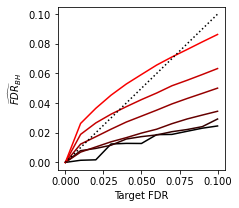

In [135]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fdps_BH_bst[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat{FDR}_{BH}$");# plt.legend()

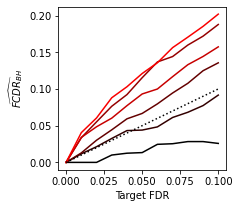

In [136]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fcdps_BH_bst[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat{FCDR}_{BH}$"); #plt.legend()

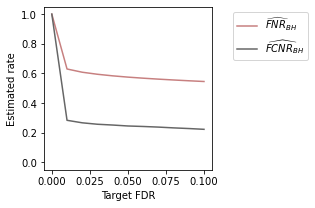

In [137]:
plt.figure(figsize=(3,3))
plt.plot(alphas, np.mean(fnps_BH_bst, (0,1)), color=(200/256, 128/256, 128/256), label=r"$\widehat{FNR}_{BH}$")
plt.plot(alphas, np.mean(fcnps_BH_bst, (0,1)), color=(102/256, 102/256, 102/256), label = r"$\widehat{FCNR}_{BH}$")
plt.xlabel(r"Target FDR"); plt.ylabel(r"Estimated rate"); plt.ylim(-0.05,1.05)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

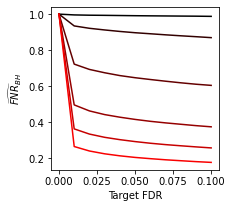

In [138]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fnps_BH_bst[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat{FNR}_{BH}$"); #plt.legend()

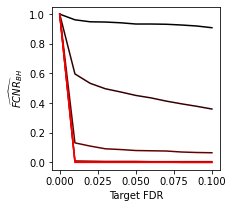

In [139]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fcnps_BH_bst[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat{FCNR}_{BH}$"); #plt.legend()

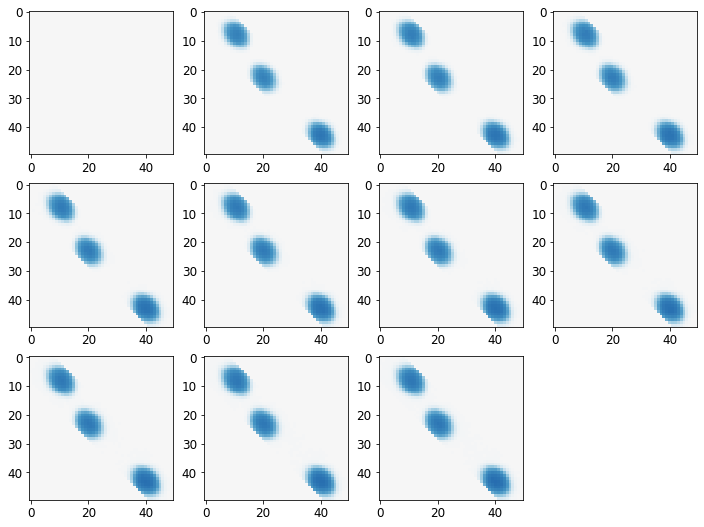

In [551]:
plt.figure(figsize=(12,9))
for iter_alpha, alpha in enumerate(alphas):
    plt.subplot(3, 4, iter_alpha+1)
    ldn.imshow(np.mean(rejs_BH_bst[:,:,iter_alpha], (0,1)), cmap='RdBu', vmax=1, vmin=-1)

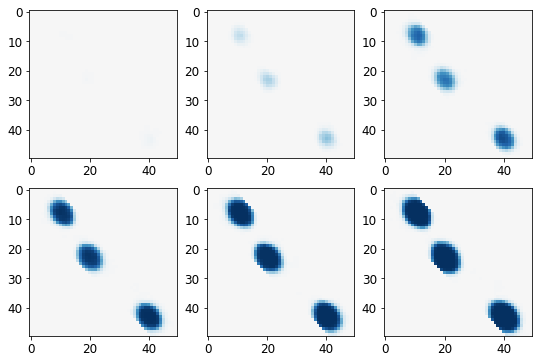

In [553]:
plt.figure(figsize=(9,6))
for iter_snr, snr in enumerate(snrs):
    plt.subplot(2, 3, iter_snr+1)
    ldn.imshow(np.mean(rejs_BH_bst[iter_snr,:,1], (0)), cmap='RdBu', vmax=1, vmin=-1)

# 4. excursion test

In [88]:
a_BH = 0.05
alphas = np.linspace(0, 0.1, 11)

In [89]:
pvals_exc_blob = np.full((len(snrs), num_sim, num_blobs), 0.5)
pvals_exc_null = np.full((len(snrs), num_sim), None, dtype=object)
rbs_pexc = np.zeros((len(snrs), num_sim,) + alphas.shape + (num_time, num_time))
nbs_pexc = np.zeros((len(snrs), num_sim,) + alphas.shape)

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        sys.__stdout__.write("%d-%d-th simulation\n"%(iter_snr+1, iter_sim+1))
        sys.__stdout__.flush()

        result = np.load("%s/result_sim_%.1d_%.3d.npz"%(save_dir,iter_snr,iter_sim))
        Omega_est=result["Omega_est"]; Sigma_est=result["Sigma_est"]
        Omegas_perm=result["Omegas_bst"]; Sigmas_perm=result["Sigmas_bst"]

        dspr_est = 2*Omega_est - Omega_est@(Sigma_est + lambda_diag*np.eye(2*num_time))@Omega_est
        dsprs_perm = 2*Omegas_perm - Omegas_perm@(Sigmas_perm + lambda_diag*np.eye(2*num_time))@Omegas_perm
        dist_dspr_est = (dspr_est[:num_time,num_time:] / np.std(dsprs_perm[:,:num_time,num_time:],0))
        dist_dspr_perm = (dsprs_perm[:,:num_time,num_time:]
                         / np.std(dsprs_perm[:,:num_time,num_time:],0))
        
        pval_est = np.full(dist_dspr_est.shape, 0.5)
        pvals_perm = np.full(dist_dspr_perm.shape, 0.5)
        pval_est[roi] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_est[roi])), 1e-10, 1-1e-10)
        pvals_perm[:,roi] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_perm[:,roi])), 1e-10, 1-1e-10)
        
#         pval_est[roi] = 1-(ranks[:np.sum(roi)]/len(temp) - 1/(2*len(temp)))
#         pvals_perm[:,roi] = 1-(ranks[np.sum(roi):].reshape((num_perm,np.sum(roi)))/len(temp) - 1/(2*len(temp)))

        # BH procedure
        p_sorted = np.concatenate([[0], np.sort(pval_est[roi].flatten())])
        k_hat = np.max(np.where(np.linspace(0, a_BH, len(p_sorted)) >= p_sorted))        
        rej_BH_est = pval_est <= k_hat * a_BH / (len(p_sorted)-1)

#         p_sorted = np.concatenate([[0], np.sort(pvals_perm[:,roi].flatten())])   
#         k_hat = np.max(np.where(np.linspace(0, a_BH, len(p_sorted)) >= p_sorted))        
        rejs_BH_perm = pvals_perm <= k_hat * a_BH / (len(p_sorted)-1)

        rb_BH_est = np.zeros((num_time, num_time))
        mask_cp = rej_BH_est.copy(); iter_blob = 0
        while np.any(mask_cp):
            iter_blob += 1
            queue = [tuple(np.transpose(np.where(mask_cp))[0])]
            mask_cp[queue[0]] = False
            while len(queue) > 0:
                cur = queue.pop(0)
                rb_BH_est[cur[0], cur[1]] = iter_blob
                if cur[0] > 0:
                    if mask_cp[cur[0]-1, cur[1]]:
                        queue.append((cur[0]-1, cur[1]))
                        mask_cp[cur[0]-1, cur[1]] = False
                if cur[0] < num_time-1:
                    if mask_cp[cur[0]+1, cur[1]]:
                        queue.append((cur[0]+1, cur[1]))
                        mask_cp[cur[0]+1, cur[1]] = False
                if cur[1] > 0:
                    if mask_cp[cur[0], cur[1]-1]:
                        queue.append((cur[0], cur[1]-1))
                        mask_cp[cur[0], cur[1]-1] = False
                if cur[1] < num_time-1:
                    if mask_cp[cur[0], cur[1]+1]:
                        queue.append((cur[0], cur[1]+1))
                        mask_cp[cur[0], cur[1]+1] = False
        nb_BH_est = iter_blob

        rbs_BH_perm = np.zeros((num_perm, num_time, num_time))
        nbs_BH_perm = np.zeros((num_perm,))
        for iter_perm in range(num_perm):
            mask_cp = rejs_BH_perm[iter_perm].copy(); iter_blob = 0
            while np.any(mask_cp):
                iter_blob += 1
                queue = [tuple(np.transpose(np.where(mask_cp))[0])]
                mask_cp[queue[0]] = False
                while len(queue) > 0:
                    cur = queue.pop(0)
                    rbs_BH_perm[iter_perm, cur[0], cur[1]] = iter_blob
                    if cur[0] > 0:
                        if mask_cp[cur[0]-1, cur[1]]:
                            queue.append((cur[0]-1, cur[1]))
                            mask_cp[cur[0]-1, cur[1]] = False
                    if cur[0] < num_time-1:
                        if mask_cp[cur[0]+1, cur[1]]:
                            queue.append((cur[0]+1, cur[1]))
                            mask_cp[cur[0]+1, cur[1]] = False
                    if cur[1] > 0:
                        if mask_cp[cur[0], cur[1]-1]:
                            queue.append((cur[0], cur[1]-1))
                            mask_cp[cur[0], cur[1]-1] = False
                    if cur[1] < num_time-1:
                        if mask_cp[cur[0], cur[1]+1]:
                            queue.append((cur[0], cur[1]+1))
                            mask_cp[cur[0], cur[1]+1] = False
            nbs_BH_perm[iter_perm] = iter_blob

        mrois_BH_perm = np.zeros(num_perm)
        for iter_perm, (pval, rej_b, num_b) \
        in enumerate(zip(pvals_perm, rbs_BH_perm, nbs_BH_perm)):
            rois = np.zeros(int(num_b+1))
            for iter_blob in range(1, int(num_b+1)):
                rois[iter_blob] = np.sum(-np.log(pval[rej_b == iter_blob]))
            mrois_BH_perm[iter_perm] = np.max(rois)

        rois_BH_est = np.zeros(nb_BH_est+1)
        for iter_blob in range(1, nb_BH_est+1):
            rois_BH_est[iter_blob] = np.sum(-np.log(pval_est[rb_BH_est == iter_blob]))
        p_rois_BH = np.mean(rois_BH_est <= mrois_BH_perm[:,None], 0)
        
        for iter_alpha, alpha in enumerate(alphas):
            temp = np.array(
                [rb_BH_est == i for i in range(int(nb_BH_est+1))]
            ).reshape([-1,num_time,num_time])
            nbs_pexc[iter_snr,iter_sim,iter_alpha] = np.sum(p_rois_BH < alpha)
            rbs_pexc[iter_snr,iter_sim,iter_alpha] = np.sum(temp[p_rois_BH < alpha] \
                * np.arange(1,np.sum(p_rois_BH < alpha)+1)[:,None,None], 0)
            
        for i, H0_i in enumerate(H0):
            pvals_exc_blob[iter_snr,iter_sim,i] \
            = np.min(np.concatenate([[1],
                 p_rois_BH[rb_BH_est[np.logical_and(H0[i]>0, rb_BH_est>0)].astype(int)]]))
            
        pvals_exc_null[iter_snr,iter_sim] \
        = np.min(p_rois_BH[~np.isin(np.arange(nb_BH_est+1),
                        rb_BH_est[np.logical_and(np.sum(H0,0)>0, rb_BH_est>0)].astype(int))])
            
#         for iter_blob in np.arange(num_blobs):
#             rbs_H0 = rb_BH_est[H0[iter_blob] == 1]
#             if np.sum(rbs_H0!=0) <=1:
#                 pvals_exc_blob[iter_snr,iter_sim,iter_blob] = np.nan
#             else:
#                 urbs, urbs_counts = np.unique(rbs_H0[rbs_H0!=0], return_counts=True)
#                 pvals_exc_blob[iter_snr,iter_sim,iter_blob] = \
#                     p_rois_BH[int(urbs[urbs_counts.argmax()])]
        
#         pvals_exc_null[iter_snr,iter_sim] = \
#             p_rois_BH[
#                 ~np.isin(np.arange(nb_BH_est+1),np.unique(np.sum(H0, 0) * rb_BH_est))]

1-1-th simulation
1-2-th simulation
1-3-th simulation
1-4-th simulation
1-5-th simulation
1-6-th simulation
1-7-th simulation
1-8-th simulation
1-9-th simulation
1-10-th simulation
1-11-th simulation
1-12-th simulation
1-13-th simulation
1-14-th simulation
1-15-th simulation
1-16-th simulation
1-17-th simulation
1-18-th simulation
1-19-th simulation
1-20-th simulation
1-21-th simulation
1-22-th simulation
1-23-th simulation
1-24-th simulation
1-25-th simulation
1-26-th simulation
1-27-th simulation
1-28-th simulation
1-29-th simulation
1-30-th simulation
1-31-th simulation
1-32-th simulation
1-33-th simulation
1-34-th simulation
1-35-th simulation
1-36-th simulation
1-37-th simulation
1-38-th simulation
1-39-th simulation
1-40-th simulation
1-41-th simulation
1-42-th simulation
1-43-th simulation
1-44-th simulation
1-45-th simulation
1-46-th simulation
1-47-th simulation
1-48-th simulation
1-49-th simulation
1-50-th simulation
1-51-th simulation
1-52-th simulation
1-53-th simulation
1-

3-23-th simulation
3-24-th simulation
3-25-th simulation
3-26-th simulation
3-27-th simulation
3-28-th simulation
3-29-th simulation
3-30-th simulation
3-31-th simulation
3-32-th simulation
3-33-th simulation
3-34-th simulation
3-35-th simulation
3-36-th simulation
3-37-th simulation
3-38-th simulation
3-39-th simulation
3-40-th simulation
3-41-th simulation
3-42-th simulation
3-43-th simulation
3-44-th simulation
3-45-th simulation
3-46-th simulation
3-47-th simulation
3-48-th simulation
3-49-th simulation
3-50-th simulation
3-51-th simulation
3-52-th simulation
3-53-th simulation
3-54-th simulation
3-55-th simulation
3-56-th simulation
3-57-th simulation
3-58-th simulation
3-59-th simulation
3-60-th simulation
3-61-th simulation
3-62-th simulation
3-63-th simulation
3-64-th simulation
3-65-th simulation
3-66-th simulation
3-67-th simulation
3-68-th simulation
3-69-th simulation
3-70-th simulation
3-71-th simulation
3-72-th simulation
3-73-th simulation
3-74-th simulation
3-75-th simu

5-45-th simulation
5-46-th simulation
5-47-th simulation
5-48-th simulation
5-49-th simulation
5-50-th simulation
5-51-th simulation
5-52-th simulation
5-53-th simulation
5-54-th simulation
5-55-th simulation
5-56-th simulation
5-57-th simulation
5-58-th simulation
5-59-th simulation
5-60-th simulation
5-61-th simulation
5-62-th simulation
5-63-th simulation
5-64-th simulation
5-65-th simulation
5-66-th simulation
5-67-th simulation
5-68-th simulation
5-69-th simulation
5-70-th simulation
5-71-th simulation
5-72-th simulation
5-73-th simulation
5-74-th simulation
5-75-th simulation
5-76-th simulation
5-77-th simulation
5-78-th simulation
5-79-th simulation
5-80-th simulation
5-81-th simulation
5-82-th simulation
5-83-th simulation
5-84-th simulation
5-85-th simulation
5-86-th simulation
5-87-th simulation
5-88-th simulation
5-89-th simulation
5-90-th simulation
5-91-th simulation
5-92-th simulation
5-93-th simulation
5-94-th simulation
5-95-th simulation
5-96-th simulation
5-97-th simu

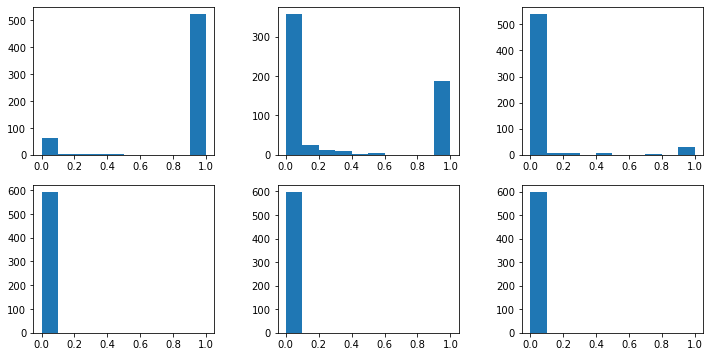

In [90]:
fig, axes = plt.subplots(2, 3, #sharey=True, sharex=True,
                         figsize=[12.0, 6.0], facecolor='white')
plt.subplots_adjust(wspace=0.35)
for iter_snr, (snr, ax) in enumerate(zip(snrs, axes.flatten())):
    ax.hist(pvals_exc_blob[iter_snr].flatten(), range=(0,1))

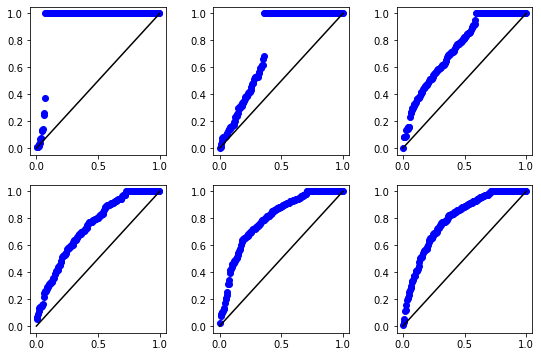

In [107]:
fig, axes = plt.subplots(2, 3, #sharey=True, sharex=True,
                         figsize=[9.0, 6.0], facecolor='white')
plt.subplots_adjust(wspace=0.35)
for iter_snr, (snr, ax) in enumerate(zip(snrs, axes.flatten())):
    stats.probplot(pvals_exc_null[iter_snr], dist='uniform', fit=False, plot=ax)
    ax.plot((0,1),(0,1), color='black')
    ax.set_xlabel(r''); ax.set_ylabel(r'')
    ax.set_title('')

Text(0, 0.5, 'Ordered p-values of \n null clusters')

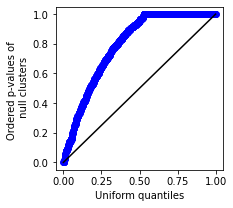

In [108]:
plt.figure(figsize=(3,3))
stats.probplot(pvals_exc_null.flatten(), dist='uniform', fit=False, plot=plt)
plt.plot((0,1),(0,1), color='black')
plt.title("")
plt.xlabel("Uniform quantiles"); plt.ylabel("Ordered p-values of \n null clusters")

In [113]:
p_nominal = np.linspace(0, 1, 2001)
TPR = np.mean(pvals_exc_blob[...,None] <= p_nominal, (1,2), where= pvals_exc_blob[...,None] < 1)
FPR = np.mean(pvals_exc_null[...,None] <= p_nominal, (1))

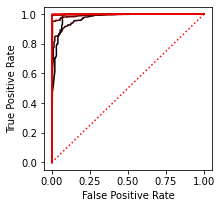

In [114]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(np.concatenate([[0],FPR[iter_snr]]), np.concatenate([[0],TPR[iter_snr]]),
             color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.plot([0,1],[0,1], color='red', ls=':')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); #plt.legend()

Text(0, 0.5, 'True Positive Rate')

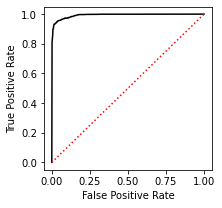

In [115]:
plt.figure(figsize=(3,3))
plt.plot(np.concatenate([[0],np.mean(FPR,0)]), np.concatenate([[0],np.mean(TPR,0)]), color='black')
plt.plot([0,1],[0,1], color='red', ls=':')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")

In [116]:
np.sum((np.nanmean(TPR,0)[1:]+np.nanmean(TPR,0)[:-1]) 
       * (np.nanmean(FPR,0)[1:]-np.nanmean(FPR,0)[:-1]),0) / 2

0.9917955823459876

## calculate fdrs

In [581]:
rejs_pexc = np.minimum(rbs_pexc, 1)

In [582]:
fdps_pexc = np.sum(rejs_pexc > H0_sm[:,None,None], (-2,-1)) \
           / np.maximum(np.sum(rejs_pexc, (-2,-1)), 1)   

fnps_pexc = np.sum(rejs_pexc < H0_sm[:,None,None], (-2,-1)) \
               / np.maximum(np.sum(H0_sm,(-1,-2)), 1)[:,None,None]

In [583]:
fcds_pexc = nbs_pexc.copy()
for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        for iter_alpha, _ in enumerate(alphas):
            fcds_pexc[iter_snr, iter_sim, iter_alpha] -= np.sum(np.unique(
                rbs_pexc[iter_snr, iter_sim, iter_alpha, np.any(H0,0)])> 0)
        
fcdps_pexc = fcds_pexc / np.maximum(nbs_pexc, 1)

In [584]:
fcnps_pexc = np.sum(np.all(
    np.logical_or((rejs_pexc[...,None,:,:] < H0), np.logical_not(H0))
    , (-2,-1)), -1) /np.maximum(H0.shape[0], 1)

## plots

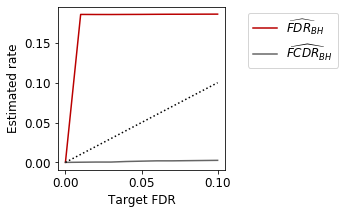

In [674]:
plt.figure(figsize=(3,3))
plt.plot(alphas, np.mean(fdps_pexc, (0,1)), color=(187/256, 0, 0), label=r"$\widehat{FDR}_{BH}$")
plt.plot(alphas, np.mean(fcdps_pexc, (0,1)), color=(102/256, 102/256, 102/256), label = r"$\widehat{FCDR}_{BH}$")
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"Estimated rate") #; plt.ylim(-0.02, 0.32)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

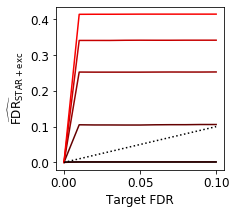

In [587]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fdps_pexc[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FDR}_\mathrm{STAR+exc}$"); #plt.legend()

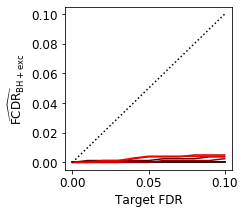

In [670]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fcdps_pexc[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FCDR}_\mathrm{BH+exc}$"); #plt.legend()

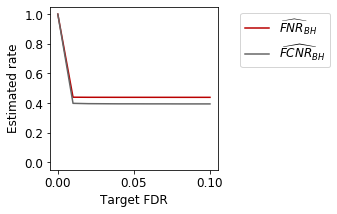

In [671]:
plt.figure(figsize=(3,3))
plt.plot(alphas, np.mean(fnps_pexc, (0,1)), color=(187/256, 0, 0), label = r"$\widehat{FNR}_{BH}$")
plt.plot(alphas, np.mean(fcnps_pexc, (0,1)), color=(102/256, 102/256, 102/256), label = r"$\widehat{FCNR}_{BH}$")
plt.xlabel(r"Target FDR"); plt.ylabel(r"Estimated rate"); plt.ylim(-0.05,1.05)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

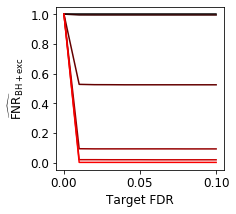

In [669]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fnps_pexc[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FNR}_\mathrm{BH+exc}$"); #plt.legend()

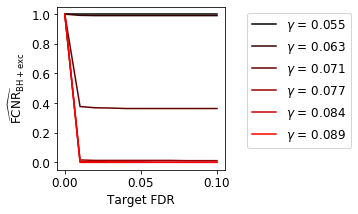

In [673]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fcnps_pexc[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"$\gamma$ = %.3f"%snr)
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FCNR}_\mathrm{BH+exc}$"); 
plt.legend(bbox_to_anchor=(1.1,1))

# 5. Granger Causality

In [632]:
bw = 10
order = 5
lambda_reg = lambda_diag # 1.5
lags_cond = np.array([1,2])

In [633]:
GCs_sim = np.zeros([len(snrs), num_sim, num_time, 2])

In [641]:
for iter_snr, snr in enumerate(snrs):
    for iter_sim in np.arange(num_sim):
        for end_time in np.arange(bw, num_time):
            Sigma_tw = (Sigmas_sim[iter_snr,iter_sim].reshape([2,num_time,2,num_time])
                [:,end_time-bw:end_time,:,end_time-bw:end_time])

            Sigma_ar = np.mean([Sigma_tw[:,i+order:i:-1,:,i+order:i:-1] 
                for i in np.arange(bw-order)], 0).reshape((2*order,2*order))

            id_ar1 = np.concatenate([np.arange(order),lags_cond+order])
            id_ar2 = np.concatenate([np.arange(order)+order,lags_cond])
            id_ar12 = np.concatenate([np.arange(order),np.arange(1,order)+order])
            id_ar21 = np.concatenate([np.arange(order)+order,np.arange(1,order)])

            lcov_ar1 = Sigma_ar[np.ix_(id_ar1,id_ar1)]
            lcov_ar2 = Sigma_ar[np.ix_(id_ar2,id_ar2)]
            lcov_ar12 = Sigma_ar[np.ix_(id_ar12,id_ar12)]
            lcov_ar21 = Sigma_ar[np.ix_(id_ar21,id_ar21)]

            lcov_ar1 = lcov_ar1 + lambda_reg * np.eye(lcov_ar1.shape[0])
            lcov_ar2 = lcov_ar2 + lambda_reg * np.eye(lcov_ar2.shape[0])
            lcov_ar12 = lcov_ar12 + lambda_reg * np.eye(lcov_ar12.shape[0])
            lcov_ar21 = lcov_ar21 + lambda_reg * np.eye(lcov_ar21.shape[0])

            mse_ar1 = lcov_ar1[0,0] - lcov_ar1[0,1:]@np.linalg.inv(lcov_ar1[1:,1:])@lcov_ar1[0,1:]
            mse_ar2 = lcov_ar2[0,0] - lcov_ar2[0,1:]@np.linalg.inv(lcov_ar2[1:,1:])@lcov_ar2[0,1:]

            mse_ar12 = lcov_ar12[0,0] - lcov_ar12[0,1:]@np.linalg.inv(lcov_ar12[1:,1:])@lcov_ar12[0,1:]
            mse_ar21 = lcov_ar21[0,0] - lcov_ar21[0,1:]@np.linalg.inv(lcov_ar21[1:,1:])@lcov_ar21[0,1:]

            GCs_sim[iter_snr, iter_sim, end_time] = (
                np.log(mse_ar1) - np.log(mse_ar12), 
                np.log(mse_ar2) - np.log(mse_ar21))

## permutation bootstrap

In [647]:
num_perm = Sigmas_perm.shape[0]
GCs_perm_max = np.zeros([len(snrs), num_sim, num_perm, 2])

In [651]:
for iter_snr, snr in enumerate(snrs):
    for iter_sim in np.arange(num_sim):
        sys.__stdout__.write("%d-%d-th simulation\n"%(iter_snr+1, iter_sim+1))
        sys.__stdout__.flush()

        result = np.load("%s/result_sim_%.1d_%.3d.npz"%(save_dir,iter_snr, iter_sim))
        Sigmas_perm=result["Sigmas_bst"]
        
        GCs_perm = np.zeros([num_perm, num_time, 2])
        for iter_perm in np.arange(num_perm):
            for end_time in np.arange(bw, num_time):
                Sigma_tw = (Sigmas_perm[iter_perm].reshape([2,num_time,2,num_time])
                    [:,end_time-bw:end_time,:,end_time-bw:end_time])

                Sigma_ar = np.mean([Sigma_tw[:,i+order:i:-1,:,i+order:i:-1] 
                    for i in np.arange(bw-order)], 0).reshape((2*order,2*order))

                id_ar1 = np.concatenate([np.arange(order),lags_cond+order])
                id_ar2 = np.concatenate([np.arange(order)+order,lags_cond])
                id_ar12 = np.concatenate([np.arange(order),np.arange(1,order)+order])
                id_ar21 = np.concatenate([np.arange(order)+order,np.arange(1,order)])

                lcov_ar1 = Sigma_ar[np.ix_(id_ar1,id_ar1)]
                lcov_ar2 = Sigma_ar[np.ix_(id_ar2,id_ar2)]
                lcov_ar12 = Sigma_ar[np.ix_(id_ar12,id_ar12)]
                lcov_ar21 = Sigma_ar[np.ix_(id_ar21,id_ar21)]

                lcov_ar1 = lcov_ar1 + lambda_reg * np.eye(lcov_ar1.shape[0])
                lcov_ar2 = lcov_ar2 + lambda_reg * np.eye(lcov_ar2.shape[0])
                lcov_ar12 = lcov_ar12 + lambda_reg * np.eye(lcov_ar12.shape[0])
                lcov_ar21 = lcov_ar21 + lambda_reg * np.eye(lcov_ar21.shape[0])

                mse_ar1 = lcov_ar1[0,0] - lcov_ar1[0,1:]@np.linalg.inv(lcov_ar1[1:,1:])@lcov_ar1[0,1:]
                mse_ar2 = lcov_ar2[0,0] - lcov_ar2[0,1:]@np.linalg.inv(lcov_ar2[1:,1:])@lcov_ar2[0,1:]

                mse_ar12 = lcov_ar12[0,0] - lcov_ar12[0,1:]@np.linalg.inv(lcov_ar12[1:,1:])@lcov_ar12[0,1:]
                mse_ar21 = lcov_ar21[0,0] - lcov_ar21[0,1:]@np.linalg.inv(lcov_ar21[1:,1:])@lcov_ar21[0,1:]

                GCs_perm[iter_perm,end_time] = \
                    (np.log(mse_ar1) - np.log(mse_ar12), 
                     np.log(mse_ar2) - np.log(mse_ar21))
                
        GCs_perm_max[iter_snr,iter_sim] = np.max(GCs_perm,1)

1-1-th simulation
1-2-th simulation
1-3-th simulation
1-4-th simulation
1-5-th simulation
1-6-th simulation
1-7-th simulation
1-8-th simulation
1-9-th simulation
1-10-th simulation
1-11-th simulation
1-12-th simulation
1-13-th simulation
1-14-th simulation
1-15-th simulation
1-16-th simulation
1-17-th simulation
1-18-th simulation
1-19-th simulation
1-77-th simulation
1-78-th simulation
1-79-th simulation
1-80-th simulation
1-81-th simulation
1-82-th simulation
1-83-th simulation
1-84-th simulation
1-85-th simulation
1-86-th simulation
1-87-th simulation
1-88-th simulation
1-89-th simulation
1-90-th simulation
1-91-th simulation
1-92-th simulation
1-93-th simulation
1-94-th simulation
1-95-th simulation
1-96-th simulation
1-97-th simulation
1-98-th simulation
1-99-th simulation
1-100-th simulation
1-101-th simulation
1-102-th simulation
1-103-th simulation
1-104-th simulation
1-105-th simulation
1-106-th simulation
1-107-th simulation
1-108-th simulation
1-109-th simulation
1-110-th si

3-80-th simulation
3-81-th simulation
3-82-th simulation
3-83-th simulation
3-84-th simulation
3-85-th simulation
3-86-th simulation
3-87-th simulation
3-88-th simulation
3-89-th simulation
3-90-th simulation
3-91-th simulation
3-92-th simulation
3-93-th simulation
3-94-th simulation
3-95-th simulation
3-96-th simulation
3-97-th simulation
3-98-th simulation
3-99-th simulation
3-100-th simulation
3-101-th simulation
3-102-th simulation
3-103-th simulation
3-104-th simulation
3-105-th simulation
3-106-th simulation
3-107-th simulation
3-108-th simulation
3-109-th simulation
3-110-th simulation
3-111-th simulation
3-112-th simulation
3-113-th simulation
3-114-th simulation
3-115-th simulation
3-116-th simulation
3-117-th simulation
3-118-th simulation
3-119-th simulation
3-120-th simulation
3-121-th simulation
3-122-th simulation
3-123-th simulation
3-124-th simulation
3-125-th simulation
3-126-th simulation
3-127-th simulation
3-128-th simulation
3-129-th simulation
3-130-th simulation


5-102-th simulation
5-103-th simulation
5-104-th simulation
5-105-th simulation
5-106-th simulation
5-107-th simulation
5-108-th simulation
5-109-th simulation
5-110-th simulation
5-111-th simulation
5-112-th simulation
5-113-th simulation
5-114-th simulation
5-115-th simulation
5-116-th simulation
5-117-th simulation
5-118-th simulation
5-119-th simulation
5-120-th simulation
5-121-th simulation
5-122-th simulation
5-123-th simulation
5-124-th simulation
5-125-th simulation
5-126-th simulation
5-127-th simulation
5-128-th simulation
5-129-th simulation
5-130-th simulation
5-131-th simulation
5-132-th simulation
5-133-th simulation
5-134-th simulation
5-135-th simulation
5-136-th simulation
5-137-th simulation
5-138-th simulation
5-139-th simulation
5-140-th simulation
5-141-th simulation
5-142-th simulation
5-143-th simulation
5-144-th simulation
5-145-th simulation
5-146-th simulation
5-147-th simulation
5-148-th simulation
5-149-th simulation
5-150-th simulation
5-151-th simulation


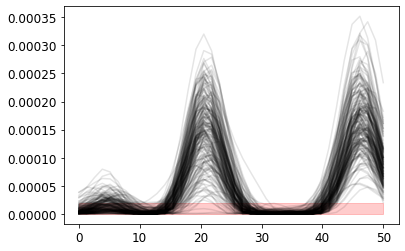

In [667]:
plt.plot(np.linspace(0,50,num_time-bw),
         GCs_sim[3,:,bw:,0].T, color='black', alpha=0.1)
plt.fill_between(
    np.linspace(0,50,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
    np.mean(np.quantile(GCs_perm_max[3,:,:,0],0.95,1)),
    color='red', alpha=0.2)

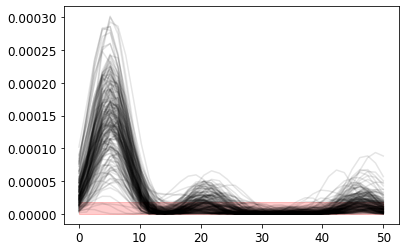

In [666]:
plt.plot(np.linspace(0,50,num_time-bw),
         GCs_sim[3,:,bw:,1].T, color='black', alpha=0.1)
plt.fill_between(
    np.linspace(0,50,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
    np.mean(np.quantile(GCs_perm_max[3,:,:,1],0.95,1)),
    color='red', alpha=0.2)